In [1]:
from scipy.spatial import distance as dst
from mpl_toolkits.basemap import Basemap
from collections import defaultdict
import matplotlib.pyplot as plt
import shapely.geometry as sp
import datetime as dt
import pandas as pd
import pickle as pk
import numpy as np
import itertools
import math
import time
import json
import copy

<div>
<font size="4",style="font-family:Ubuntu"> <p> The following two cells demonstrates the two main csv files we will be working with in the notebook. The cleaned versions of FlightTracks.csv(cleanTracks.csv) and Flight_History.csv(cleanFlights.csv)</p></font><br>
<font size="3">
<b>Input</b> &rarr; cleanTracks.csv, cleanFlightHistory.csv <br>
</div>

In [3]:
cleanTracks=pd.read_csv("Outputs/cleanTracks.csv")
cleanTracks

,received,ground_speed,latitude_degrees,longitude_degrees,flighthistory_id
0,2013-08-14 08:30:56,172,36.207200,-79.425000,306095730
1,2013-08-14 08:31:56,187,36.259400,-79.430000,306095730
2,2013-08-14 08:32:53,214,36.326700,-79.418100,306095730
3,2013-08-14 08:33:53,191,36.363100,-79.383600,306095730
4,2013-08-14 08:34:59,186,36.402200,-79.336400,306095730
...,...,...,...,...,...
81406058,2013-09-11 13:57:30,316,42.680000,-106.449997,308962199
81406059,2013-09-11 13:58:31,279,42.700001,-106.529999,308962199
81406060,2013-09-11 13:59:32,250,42.720001,-106.620003,308962199
81406061,2013-09-11 14:24:46,130,37.630001,-122.099998,308960729


In [4]:
cleanFlights=pd.read_csv("Outputs/cleanFlightHistory.csv")
cleanFlights

,id,departure_airport_icao_code,arrival_airport_icao_code,scheduled_runway_departure,actual_runway_departure,scheduled_runway_arrival,actual_runway_arrival
0,305966493,KSDF,KDEC,2013-08-14 08:40:00,2013-08-14 09:14:00,2013-08-14 09:44:00,2013-08-14 10:12:00
1,306196254,KSDF,KBHM,2013-08-14 09:00:00,2013-08-14 09:04:00,2013-08-14 09:47:00,2013-08-14 09:51:00
2,306196711,KMEM,KCOS,2013-08-14 09:00:00,2013-08-14 09:14:00,2013-08-14 11:01:00,2013-08-14 11:18:00
3,306196678,KMEM,KMIA,2013-08-14 09:00:00,2013-08-14 09:09:00,2013-08-14 10:52:00,2013-08-14 10:58:00
4,306196521,KSDF,KMKE,2013-08-14 09:00:00,2013-08-14 09:15:00,2013-08-14 09:54:00,2013-08-14 10:04:00
...,...,...,...,...,...,...,...
646704,308962754,KMEM,KSAN,2013-09-11 08:58:00,2013-09-11 09:04:00,2013-09-11 12:07:00,2013-09-11 12:09:00
646705,308961528,KSDF,KSGF,2013-09-11 08:59:00,2013-09-11 09:08:00,2013-09-11 10:03:00,2013-09-11 10:03:00
646706,308962550,KMEM,KRIC,2013-09-11 08:59:00,2013-09-11 09:11:00,2013-09-11 10:37:00,2013-09-11 10:46:00
646707,308962750,KSDF,KHSV,2013-09-11 08:59:00,2013-09-11 09:16:00,2013-09-11 09:58:00,2013-09-11 10:26:00


<div>
<font size="4",style="font-family:Ubuntu"> <p> The following cell reads the cleanTracks.csv which has a mapping between every flight and its corresponding ground speed in knots captured at 1 minute intervals(timestamps) and outputs the dictionary as a pickle file that maps each flightID to its median ground speed/cruise speed. </p></font><br>
<font size="3">
<b>Input</b> &rarr; cleanTracks.csv <br>
<b>Output</b> &rarr; SpeedDict.pkl </font>
</div>

In [3]:
cleanTracks=pd.read_csv("Outputs/cleanTracks.csv")
cleanTracks.sort_values(by=['received'],inplace=True)
speeds = cleanTracks.groupby(["flighthistory_id"])["ground_speed"].median()
df_dict = speeds.to_dict()
avg_speed = np.array(list(df_dict.values())).mean()
med_speed = np.median(list(df_dict.values()))
print("The Average Cruise Speed of a flight is ",avg_speed)
print("The Median Cruise Speed of a flight is ",med_speed)
print("The Number of flights whose cruise speed is known",len(df_dict))
speedDictFile=open("Outputs/SpeedDict.pkl","wb")
pk.dump(df_dict,speedDictFile)
speedDictFile.close()

The Average Cruise Speed of a flight is  386.2909277154822
The Median Cruise Speed of a flight is  407.5
The Number of flights whose cruise speed is known 631131


<h1>Test Days</h1><br>
<font size="4",style="font-family:Ubuntu"> <p> The days tested for are given below - we obtain the 3 metrics for each of the test days and compare the metric with the predicted value from the GA <br><br> Range = [2013-08-14,2013-09-11]</p></font><br>

In [2]:
TEST_DAYS=["2013-08-16"]

<p><font size="4",style="font-family:Ubuntu"> <p> The cell below creates seperate .csv files for the tracks and flights of each test day in order to reduce the IO burden, as we would not want to read the entire csv files(cleanFlightHistory and cleanTracks) for the whole month since we just want to analyze a single test day </p>
<b>Input</b> &rarr; cleanTracks.csv,cleanFlightHistory.csv <br>
<b>Output</b> &rarr; 2N csv files where N is the number of test days, for each test day we generate 2 csv files, one containing all the flights scheduled to depart that day({date}_flights.csv) and all the flight tracks recorded that day ({date}_tracks.csv) </font></font><br>

In [6]:
#cleanTracks=pd.read_csv("Outputs/cleanTracks.csv")
cleanFlights=pd.read_csv("Outputs/cleanFlightHistory.csv")
for date in TEST_DAYS:
    #tracktemp=cleanTracks[cleanTracks['received'].str.contains(date)].copy()
    flighttemp=cleanFlights[cleanFlights['scheduled_runway_departure'].str.contains(date)].copy()
    #tracktemp.to_csv(f"MetricFiles/DayWiseInput/{date}_tracks.csv",index=False)
    flighttemp.to_csv(f"MetricFiles/DayWiseInput/{date}_flights.csv",index=False)

<h1>Metric 1 - Traffic Factor</h1>

<div>
<font size="4",style="font-family:Ubuntu"> <p> The following cell block reads the {test_day}_tracks.csv which has a mapping between every flight and the coordinates of its actual path measured at constant time intervals. We use this data to obtain the TrafficFactor for each test day.<b> The Traffic Factor is a measure of the maximum number of aircraft present in every sector (measure the sector count of each sector) at any given time across the entire day.</b> </p></font><br>
<font size="3">
<b>Input</b> &rarr; {test_day}_tracks.csv <br>
<b>Output</b> &rarr; N pickle files where N is the number of days to be tested. &rarr; Each one a dict mapping each Sector to its traffic factor </font>
</div>

In [10]:
def getChunk(Point,SectorChunkDict):
    innerDict=SectorChunkDict[math.ceil(Point[0]/1000000)*1000000]
    Y=0
    for key in innerDict.keys():
        if key >= Point[1]:
            Y=key
            break
    return innerDict[Y] if Y!=0 else []
def findSectorPath(path,sectorPath,z,SectorChunkDict,output):
    sector=-1
    for pointIdx in range(len(path)):
        sectorList=getChunk(path[pointIdx],SectorChunkDict)
        for i in sectorList:
            if len(output[i]) < 3:
                continue
            if sp.Polygon(output[i]).contains(sp.Point(path[pointIdx])):
                sector=i
                break
        if sector!=-1:
            sectorPath.append(sector)
        else:
            z.append(pointIdx)
def getSectorTimings(dayTracks, m, SectorTimeDict, SectorChunkDict, ConvexHulls):
    dayTracks.sort_values(by=['flighthistory_id','received'],inplace=True)
    dayTracks=dayTracks.reset_index()
    dayTracks.drop(['index'],axis=1,inplace=True)
    east,north=m(dayTracks["longitude_degrees"],dayTracks["latitude_degrees"])
    path=list(zip(east,north))
    sectorPath=[]
    z=[]
    findSectorPath(path,sectorPath,z,SectorChunkDict,ConvexHulls)
    dayTracks.drop(z, axis=0, inplace=True)
    dayTracks=dayTracks.reset_index()
    dayTracks.drop(['index'],axis=1,inplace=True)
    timings=list(map(lambda x:dt.datetime.fromisoformat(str(x)),dayTracks["received"]))
    rowIdx=0
    NumRows=len(sectorPath)
    while rowIdx<NumRows:
        sector=sectorPath[rowIdx]
        startTime=(timings[rowIdx].hour*60)+timings[rowIdx].minute
        while rowIdx<NumRows and sectorPath[rowIdx]==sector:
            rowIdx+=1
        endTime=(timings[rowIdx-1].hour*60)+timings[rowIdx-1].minute
        for minute in range(startTime,endTime+1):
            SectorTimeDict[sector][minute]+=1

In [ ]:
ConvexHulls = pk.load(open("Outputs/ConvexDict.pkl", "rb"))
m = pk.load(open("Outputs/M_ConversionMetric.pkl", "rb"))
SectorChunkDict=pk.load(open("Outputs/SectorChunkDict.pkl", "rb"))
NumSectors=1250
TimeUnits=1440
for date in TEST_DAYS:
    SectorTimeDict=[[0 for colnum in range(TimeUnits)] for rownum in range(NumSectors)]
    dayTracks=pd.read_csv(f"MetricFiles/DayWiseInput/{date}_tracks.csv")[:NumRows]
    getSectorTimings(dayTracks,m,SectorTimeDict,SectorChunkDict,ConvexHulls)
    filehandler = open(f"MetricFiles/{date}_SectorTimeDict.pkl","wb")
    pk.dump(SectorTimeDict,filehandler)
    filehandler.close()
    TrafficFactor=dict()
    for Sectoridx in range(NumSectors):
        TrafficFactor[Sectoridx]=max(SectorTimeDict[Sectoridx])
    filehandler = open(f"MetricFiles/{date}_TrafficFactor.pkl","wb")
    pk.dump(TrafficFactor,filehandler)
    filehandler.close()

<h1>Metric 2 - Aerial Time</h1>
<h1>Metric 3 - Ground Delay</h1>

<div>
<font size="4",style="font-family:Ubuntu"> <p> The following cell block reads the {test_day}_flights.csv which details every single flight that was scheduled to depart on {test_day} We use this dataset to obtain the <b>actual aerial time </b> based on the difference between actual runway arrival and actual runway departure and the <b> ground holding delay time </b> based on the difference between actual runway departure and scheduled runway departure</p></font><br>
<font size="3">
<b>Input</b> &rarr; {test_day}_flights.csv <br>
<b>Output</b> &rarr; N csv files &rarr; each contains 2 columns, aerial time and ground delay </font>
</div>

In [7]:
for day in TEST_DAYS:
    dayDf=pd.read_csv(f"MetricFiles/DayWiseInput/{day}_flights.csv")
    display(dayDf)
    dayDf.sort_values(by=["scheduled_runway_departure"], inplace = True)
    ground_delay = []
    actual_air_time = []
    srd=list(map(lambda x:dt.datetime.fromisoformat(str(x)),dayDf["scheduled_runway_departure"]))
    ard=list(map(lambda x:dt.datetime.fromisoformat(str(x)),dayDf["actual_runway_departure"]))
    ara=list(map(lambda x:dt.datetime.fromisoformat(str(x)),dayDf["actual_runway_arrival"]))
    NumRows=len(ard)
    for i in range(NumRows):
        ground_delay.append((ard[i] - srd[i])/pd.Timedelta(minutes=1))
        actual_air_time.append((ara[i]-ard[i])/pd.Timedelta(minutes=1))
    dayno_data = pd.DataFrame()
    dayno_data.insert(0, "Aerial Time", actual_air_time)
    dayno_data.insert(1, "ground_delay", ground_delay)
    dayno_data.to_csv(f"MetricFiles/{day}-gd-aat.csv",index=False)

,id,departure_airport_icao_code,arrival_airport_icao_code,scheduled_runway_departure,actual_runway_departure,scheduled_runway_arrival,actual_runway_arrival
0,306043857,KLGA,KSTL,2013-08-16 00:00:00,2013-08-16 00:07:00,2013-08-16 02:08:00,2013-08-16 02:04:00
1,306011989,KCMH,KCLT,2013-08-16 00:00:00,2013-08-16 00:06:00,2013-08-16 01:03:00,2013-08-16 01:03:00
2,306048464,KMCO,KLAS,2013-08-16 00:00:00,2013-08-16 00:04:00,2013-08-16 04:21:00,2013-08-16 04:28:00
3,306058850,KORD,KSFO,2013-08-16 00:00:00,2013-08-16 00:00:00,2013-08-16 04:00:00,2013-08-16 04:04:00
4,306054413,KMYR,KCLT,2013-08-16 00:00:00,2013-08-15 23:47:00,2013-08-16 00:34:00,2013-08-16 00:15:00
...,...,...,...,...,...,...,...
25640,306152660,KMCI,KORD,2013-08-16 23:59:00,2013-08-16 23:50:00,2013-08-17 00:58:00,2013-08-17 00:56:00
25641,306128304,KFLL,KATL,2013-08-16 23:59:00,2013-08-16 23:55:00,2013-08-17 01:27:00,2013-08-17 01:26:00
25642,306162528,KORD,KCLE,2013-08-16 23:59:00,2013-08-16 23:59:00,2013-08-17 01:00:00,2013-08-17 00:48:00
25643,306138296,KICT,KIAH,2013-08-16 23:59:00,2013-08-17 02:10:00,2013-08-17 01:17:00,2013-08-17 03:25:00


<h1>Input File Generation</h1>

<div>
<font size="4",style="font-family:Ubuntu"> <p> The following cell generates the test files which will serve as an input to the GA via the website</p></font><br>
<font size="3">
<b>Input</b> &rarr; {test_day}_flights.csv <br>
<b>Output</b> &rarr; N txt files &rarr; each serves as a single days' worth of flights to be input to the model  </font>
</div>

In [46]:
AirportDB=json.load(open('Outputs/airports.json', encoding = "utf-8"))
speedDict=pk.load(open("Outputs/SpeedDict.pkl",'rb'))
for day in TEST_DAYS:
    dayDf=pd.read_csv(f"MetricFiles/DayWiseInput/{day}_flights.csv")[:NumFlights]
    dayDf.sort_values(by=["scheduled_runway_departure"], inplace = True)
    ids=list(dayDf['id'])
    source=list(dayDf["departure_airport_icao_code"])
    destination=list(dayDf["arrival_airport_icao_code"])
    startTime=[dt.datetime.fromisoformat(str(date)) for date in dayDf["scheduled_runway_departure"]]
    triplets=list(zip(ids,source,destination))
    start=[]
    for s in startTime:
        hour=s.hour
        minute=s.minute
        if minute < 10:
            minute="0" + str(minute)
        start.append(str(hour) + ":" + str(minute))
    toPrint=""
    for i in range(len(triplets)):
        flightID,sourceAirport,destinationAirport=triplets[i]
        sourceAirportName=AirportDB[sourceAirport]["name"]
        destinationAirportName=AirportDB[destinationAirport]["name"]
        if flightID not in speedDict:
            speedDict[flightID]=407.5
        toPrint+=f"{sourceAirportName},{destinationAirportName},1,{start[i]},{speedDict[flightID]}"
        if i!=len(triplets)-1:
            toPrint+="\n"
    f = open(f"MetricFiles/Input Text Files/{day}-pairs.txt", "w")
    f.write(toPrint)
    f.close()

<h1>Comparison Graphs</h1>

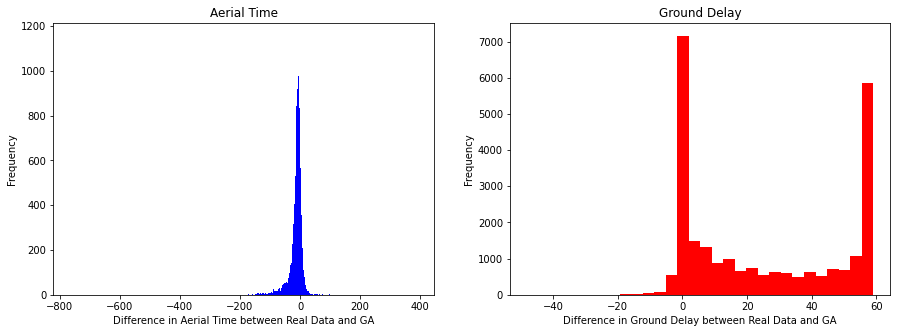

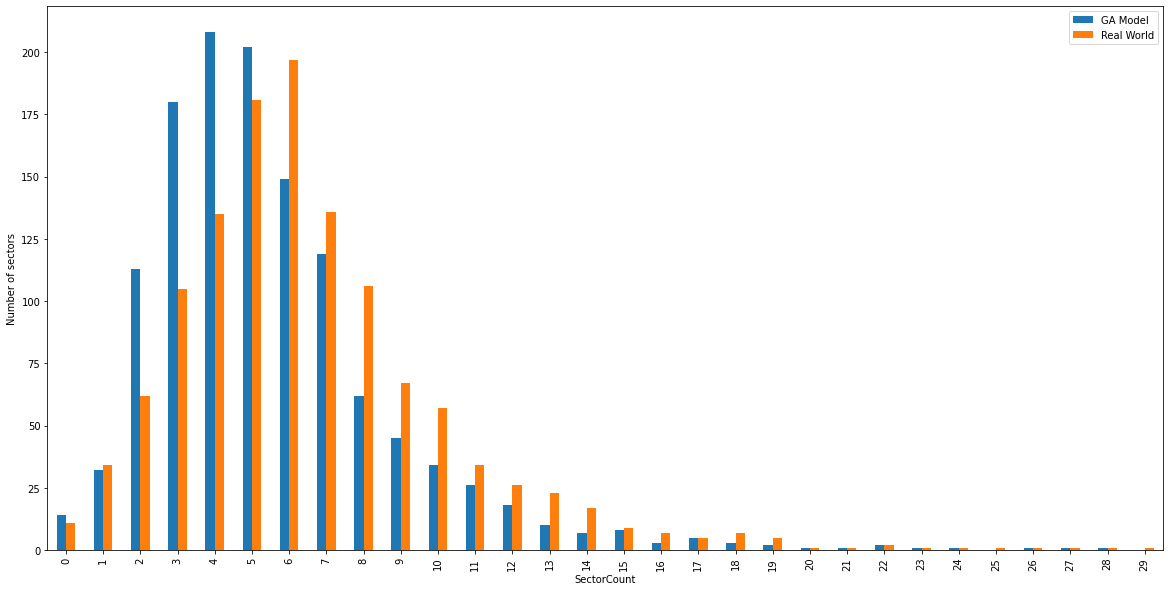

The RMSD error for Aerial Time is  31.085892868405903
The RMSD error for Ground Delay is  11.777812439071944


In [33]:
TrafficFactorGA=open("../website/backend/TrafficFactor.txt")
TrafficFactorReal = pk.load(open("MetricFiles/2013-08-16_TrafficFactor.pkl", "rb"))
MetricsGA=pd.read_csv("../website/backend/AerialTimeGD.txt")
RealMetrics=pd.read_csv("MetricFiles/2013-08-16-gd-aat.csv")
fig, ax = plt.subplots(1,2,figsize=(15,5))
realAT=RealMetrics["Aerial Time"]
GA_AT=MetricsGA["Aerial Time"]
realGD=RealMetrics["ground_delay"]
GA_GD=MetricsGA["Ground Holding"]
absDiffAT=[]
absDiffGD=[]
GATrafFactor=defaultdict(int)
RealTrafFactor=defaultdict(int)
for line in TrafficFactorGA:
    GATrafFactor[int(line)]+=1
for key,value in TrafficFactorReal.items():
    RealTrafFactor[value]+=1
data={"SectorCount":[i for i in range(30)],
     "GA Model":[GATrafFactor[sector] for sector in range(30)],
     "Real World":[RealTrafFactor[sector] for sector in range(30)]}
SectorDataFrame=pd.DataFrame(data)
for i in range(len(GA_AT)):
    absDiffAT.append(realAT[i]-GA_AT[i])
    absDiffGD.append(GA_GD[i])
q25, q75 = np.percentile(absDiffAT, [25, 75])
bin_width = 2 * (q75 - q25) * len(absDiffAT) ** (-1/3)
binsAT = round((max(absDiffAT) - min(absDiffAT)) / bin_width)

q25, q75 = np.percentile(absDiffGD, [25, 75])
bin_width = 2 * (q75 - q25) * len(absDiffGD) ** (-1/3)
binsGD = round((max(absDiffGD) - min(absDiffGD)) / bin_width)

ax[0].hist(absDiffAT, range=(min(absDiffAT),max(absDiffAT)),color='b', bins=binsAT)
ax[1].hist(absDiffGD, range=(min(absDiffGD),max(absDiffGD)),color='r', bins=binsGD)
ax[0].title.set_text('Aerial Time')
ax[1].title.set_text('Ground Delay')
ax[0].set_xlabel('Difference in Aerial Time between Real Data and GA')
ax[1].set_xlabel('Difference in Ground Delay between Real Data and GA')
ax[0].set_ylabel('Frequency')
ax[1].set_ylabel('Frequency')
SectorDataFrame.plot.bar(x='SectorCount',figsize=(20,10),ylabel = 'Number of sectors')
plt.show()
RMSE_AT=0
RMSE_GD=0
for i in range(len(GA_AT)):
    RMSE_AT+=((realAT[i]-GA_AT[i])**2)
    RMSE_GD+=((realGD[i]-GA_GD[i])**2)
RMSE_AT/=len(GA_AT)
RMSE_GD/=len(GA_AT)
RMSE_AT=RMSE_AT**(0.5)
RMSE_GD=RMSE_GD**(0.5)
print("The RMSD error for Aerial Time is ",RMSE_AT)
print("The RMSD error for Ground Delay is ",sum(realGD)/len(realGD))

In [15]:
np.median(np.array(realGD))

4.0

In [18]:
max(realGD)

681.0

In [19]:
min(realGD)

-316.0

In [23]:
x=0
for num in GA_GD:
    x+=abs(num)
print(x/len(GA_GD))

25.539286410606355


In [24]:
GA1=list(map(lambda x:abs(x),GA_GD))
real1=list(map(lambda x:abs(x),realGD))

In [29]:
np.median(np.array(GA1))

18.0

In [37]:
max(GA_GD)

59

In [38]:
df=pd.read_csv("MetricFiles/DayWiseInput/2013-08-16_flights.csv")

In [39]:
#1. convert columns to digital shit
#2. sort based on departure
#3. get actual runway dep and actual runway arrival
#4. 5 min interval find traffic

,id,departure_airport_icao_code,arrival_airport_icao_code,scheduled_runway_departure,actual_runway_departure,scheduled_runway_arrival,actual_runway_arrival
0,306043857,KLGA,KSTL,2013-08-16 00:00:00,2013-08-16 00:07:00,2013-08-16 02:08:00,2013-08-16 02:04:00
1,306011989,KCMH,KCLT,2013-08-16 00:00:00,2013-08-16 00:06:00,2013-08-16 01:03:00,2013-08-16 01:03:00
2,306048464,KMCO,KLAS,2013-08-16 00:00:00,2013-08-16 00:04:00,2013-08-16 04:21:00,2013-08-16 04:28:00
3,306058850,KORD,KSFO,2013-08-16 00:00:00,2013-08-16 00:00:00,2013-08-16 04:00:00,2013-08-16 04:04:00
4,306054413,KMYR,KCLT,2013-08-16 00:00:00,2013-08-15 23:47:00,2013-08-16 00:34:00,2013-08-16 00:15:00
...,...,...,...,...,...,...,...
25640,306152660,KMCI,KORD,2013-08-16 23:59:00,2013-08-16 23:50:00,2013-08-17 00:58:00,2013-08-17 00:56:00
25641,306128304,KFLL,KATL,2013-08-16 23:59:00,2013-08-16 23:55:00,2013-08-17 01:27:00,2013-08-17 01:26:00
25642,306162528,KORD,KCLE,2013-08-16 23:59:00,2013-08-16 23:59:00,2013-08-17 01:00:00,2013-08-17 00:48:00
25643,306138296,KICT,KIAH,2013-08-16 23:59:00,2013-08-17 02:10:00,2013-08-17 01:17:00,2013-08-17 03:25:00


In [269]:
from datetime import datetime
from collections import defaultdict
import math
def test(df,min_):
    traffic=defaultdict(list)
    trafficMax=dict()
    start=sorted(list(df["idif_actual_runway_arrival"]))[::-1][0]
    end=sorted(list(df["idif_actual_runway_departure"]))[0]
    rangeTimes=start
    minutes=rangeTimes
    ranges=minutes
    startAirports=list(df["departure_airport_icao_code"])
    endAirports=list(df["arrival_airport_icao_code"])
    departure=list(df["idif_actual_runway_departure"])
    arrival=list(df["idif_actual_runway_arrival"])
    for i in range(len(departure)):
        dep=int(departure[i]/min_)
        if len(traffic[startAirports[i]]) == 0:
            traffic[startAirports[i]]=[0 for _ in range(ranges)]
        else:
            traffic[startAirports[i]][dep]+=1
        end=int(arrival[i]/min_)
        if len(traffic[endAirports[i]]) == 0:
            traffic[endAirports[i]]=[0 for _ in range(ranges)]
        else:
            traffic[endAirports[i]][end]+=1
    for key,val in traffic.items():
        trafficMax[key]=max(val)
    return trafficMax

In [45]:
sorted(list(df["actual_runway_departure"]))[::-1][0]

'2013-08-17 06:11:00'

In [46]:
sorted(list(df["actual_runway_departure"]))[0]

'2013-08-15 23:32:00'

In [84]:
test()

In [86]:
idif=pd.read_csv("../../../../Downloads/idif.csv")

In [177]:
r=test(idif)

In [120]:
len(d.keys())

673

In [132]:
with open('MetricFiles/AerialTimeGD.txt') as f:
    lines = f.readlines()
    lines.pop(0)
    lines=list(map(lambda x:x[:-1],lines))
    lines=list(map(lambda x:[int(x.split(",")[0]),int(x.split(",")[1])],lines))

In [142]:
idif

,id,departure_airport_icao_code,arrival_airport_icao_code,scheduled_runway_departure,actual_runway_departure,scheduled_runway_arrival,actual_runway_arrival,idif_actual_runway_departure,idif_actual_runway_arrival
0,306293642,KSUU,KMCC,2013-08-16 00:55:00,2013-08-15 23:32:00,2013-08-16 01:05:00,2013-08-15 23:47:00,0,15
1,306290201,KRHI,KMKE,2013-08-16 00:01:00,2013-08-15 23:35:00,2013-08-16 01:09:00,2013-08-16 00:38:00,3,66
2,306290133,KJHW,KBUF,2013-08-16 00:09:00,2013-08-15 23:35:00,2013-08-16 00:33:00,2013-08-15 23:59:00,3,27
3,306288274,KEUG,KPDX,2013-08-16 00:45:00,2013-08-15 23:40:00,2013-08-16 01:19:00,2013-08-16 00:13:00,8,41
4,306288120,KRDM,KPDX,2013-08-16 00:20:00,2013-08-15 23:43:00,2013-08-16 01:10:00,2013-08-16 00:24:00,11,52
...,...,...,...,...,...,...,...,...,...
25640,306393072,KLAS,KIAH,2013-08-16 20:10:00,2013-08-17 03:58:00,2013-08-16 22:38:00,2013-08-17 06:22:00,1706,1850
25641,306389259,KJQF,KBUY,2013-08-16 23:40:00,2013-08-17 04:06:00,2013-08-17 00:00:00,2013-08-17 04:28:00,1714,1736
25642,306177306,KSLC,KLAX,2013-08-16 20:07:00,2013-08-17 04:16:00,2013-08-16 21:31:00,2013-08-17 05:46:00,1724,1814
25643,306174042,KSEA,KLAX,2013-08-16 22:39:00,2013-08-17 04:31:00,2013-08-17 00:50:00,2013-08-17 06:42:00,1739,1870


In [139]:
sorted(list(idif["scheduled_runway_departure"]))[0]

'2013-08-16 00:00:00'

In [141]:
x=[1,2,3]
for a,b in enumerate(x):
    print(a,b)

0 1
1 2
2 3


In [145]:
dfScheduled=pd.read_csv("../../../../Downloads/idif_scheduled.csv")

In [270]:
def GATraffic(df,min_):
    traffic=defaultdict(list)
    trafficMax=dict()
    scheduledDeparture=list(df["idif_scheduled_runway_departure"])
    ranges=int(sorted(scheduledDeparture)[-1])
    actualDeparture=[]
    actualArrival=[]
    for index,value in enumerate(scheduledDeparture):
        ac_dep=value + lines[index][1]
        actualDeparture.append(ac_dep)
        actualArrival.append(ac_dep + lines[index][0])
    startAirports=list(df["departure_airport_icao_code"])
    endAirports=list(df["arrival_airport_icao_code"])
    for i in range(len(actualDeparture)):
        dep=int(actualDeparture[i]/min_)
        if len(traffic[startAirports[i]]) == 0:
            traffic[startAirports[i]]=[0 for _ in range(ranges)]
        else:
            traffic[startAirports[i]][dep]+=1
        end=int(actualArrival[i]/min_)
        if len(traffic[endAirports[i]]) == 0:
            traffic[endAirports[i]]=[0 for _ in range(ranges)]
        else:
            traffic[endAirports[i]][end]+=1
    for key,val in traffic.items():
        trafficMax[key]=max(val)
    return trafficMax

In [195]:
p=GATraffic(dfScheduled)

In [175]:
count=0
for airport in p:
    if p[airport] <= d[airport]:
        count+=1
print(count)

561


In [150]:
d

{'KSUU': 0,
 'KMCC': 1,
 'KRHI': 1,
 'KMKE': 4,
 'KJHW': 1,
 'KBUF': 4,
 'KEUG': 2,
 'KPDX': 7,
 'KRDM': 1,
 'KMWH': 1,
 'KBFI': 4,
 'KPNS': 2,
 'KDFW': 15,
 'KIND': 5,
 'KDEN': 18,
 'KMYR': 3,
 'KCLT': 14,
 'KRST': 2,
 'KORD': 20,
 'KPIR': 1,
 'KFSD': 3,
 'KIAH': 14,
 'KTYR': 1,
 'KBJI': 1,
 'KGFK': 3,
 'KMSY': 5,
 'KSFO': 10,
 'KSTL': 7,
 'KJST': 1,
 'KIAD': 11,
 'KATL': 18,
 'KDTW': 14,
 'KOLF': 1,
 'KGTF': 2,
 'KPHL': 10,
 'KICT': 4,
 'KPHX': 11,
 'KNYL': 1,
 'KASE': 3,
 'KBOI': 3,
 'KLAS': 10,
 'KGSO': 3,
 'KMDW': 6,
 'KSAF': 2,
 'KSBY': 1,
 'KBWI': 7,
 'KBFM': 1,
 'KBHM': 3,
 'KEYW': 3,
 'KMIA': 5,
 'KTPA': 6,
 'KVIS': 2,
 'KOAK': 5,
 'KMOB': 2,
 'KRSW': 4,
 'KIGM': 1,
 'KPRC': 1,
 'KJFK': 8,
 'KFLL': 5,
 'KGRK': 2,
 'KSNA': 5,
 'KCMH': 5,
 'KMSP': 12,
 'KVPS': 3,
 'KLAW': 1,
 'KEWN': 2,
 'KRDU': 5,
 'KSMF': 5,
 'KSEA': 7,
 'KLAX': 11,
 'KSJC': 4,
 'KBOS': 11,
 'KDCA': 7,
 'KTUS': 4,
 'KIPL': 1,
 'KSAN': 7,
 'KBIL': 3,
 'KEKO': 1,
 'KSLC': 12,
 'KBTR': 2,
 'KMWA': 1,
 'KGNV': 2,


In [156]:
dfScheduled

,id,departure_airport_icao_code,arrival_airport_icao_code,scheduled_runway_departure,actual_runway_departure,scheduled_runway_arrival,actual_runway_arrival,idif_scheduled_runway_departure
0,306043857,KLGA,KSTL,2013-08-16 00:00:00,2013-08-16 00:07:00,2013-08-16 02:08:00,2013-08-16 02:04:00,28
1,306011989,KCMH,KCLT,2013-08-16 00:00:00,2013-08-16 00:06:00,2013-08-16 01:03:00,2013-08-16 01:03:00,28
2,306048464,KMCO,KLAS,2013-08-16 00:00:00,2013-08-16 00:04:00,2013-08-16 04:21:00,2013-08-16 04:28:00,28
3,306058850,KORD,KSFO,2013-08-16 00:00:00,2013-08-16 00:00:00,2013-08-16 04:00:00,2013-08-16 04:04:00,28
4,306054413,KMYR,KCLT,2013-08-16 00:00:00,2013-08-15 23:47:00,2013-08-16 00:34:00,2013-08-16 00:15:00,28
...,...,...,...,...,...,...,...,...
25640,306152660,KMCI,KORD,2013-08-16 23:59:00,2013-08-16 23:50:00,2013-08-17 00:58:00,2013-08-17 00:56:00,1467
25641,306128304,KFLL,KATL,2013-08-16 23:59:00,2013-08-16 23:55:00,2013-08-17 01:27:00,2013-08-17 01:26:00,1467
25642,306162528,KORD,KCLE,2013-08-16 23:59:00,2013-08-16 23:59:00,2013-08-17 01:00:00,2013-08-17 00:48:00,1467
25643,306138296,KICT,KIAH,2013-08-16 23:59:00,2013-08-17 02:10:00,2013-08-17 01:17:00,2013-08-17 03:25:00,1467


In [235]:
min_=10
r=test(idif,min_)
p=GATraffic(dfScheduled,min_)
count=0
for airport in p:
    if p[airport] > r[airport]:
        count+=1
print(count)

114


In [312]:
x=[]
y=[]
for min_ in range(2,481):
    r=test(idif,min_)
    p=GATraffic(dfScheduled,min_)
    count=0
    for airport in p:
        if p[airport] <= r[airport]:
            count+=1
    x.append(min_)
    y.append(count)

In [238]:
import matplotlib.pyplot as plt

In [313]:
max(y)

590

In [301]:
max(y)

569

In [283]:
len(p.keys())

673

In [314]:
590/673

0.8766716196136701

In [315]:
y

[549,
 552,
 560,
 561,
 557,
 555,
 555,
 569,
 559,
 562,
 548,
 553,
 557,
 548,
 550,
 536,
 543,
 551,
 541,
 534,
 535,
 529,
 543,
 549,
 532,
 532,
 533,
 526,
 531,
 539,
 540,
 532,
 535,
 525,
 539,
 539,
 539,
 533,
 542,
 525,
 535,
 547,
 532,
 546,
 534,
 535,
 533,
 526,
 539,
 542,
 537,
 547,
 537,
 541,
 542,
 548,
 540,
 541,
 546,
 533,
 547,
 555,
 533,
 540,
 555,
 537,
 555,
 551,
 538,
 549,
 540,
 540,
 538,
 548,
 546,
 538,
 526,
 539,
 555,
 554,
 539,
 546,
 546,
 545,
 564,
 533,
 530,
 552,
 556,
 552,
 542,
 530,
 525,
 550,
 559,
 552,
 547,
 545,
 541,
 539,
 537,
 544,
 549,
 550,
 547,
 531,
 537,
 551,
 532,
 523,
 549,
 543,
 556,
 559,
 551,
 554,
 552,
 544,
 535,
 538,
 537,
 550,
 549,
 556,
 543,
 555,
 555,
 558,
 547,
 553,
 555,
 552,
 549,
 557,
 560,
 551,
 549,
 542,
 544,
 537,
 538,
 548,
 547,
 542,
 558,
 543,
 548,
 554,
 569,
 557,
 555,
 553,
 556,
 542,
 545,
 548,
 548,
 555,
 548,
 546,
 544,
 534,
 532,
 532,
 537,
 544,
 545